In [89]:
import omegaqe
from omegaqe.fields import Fields
from omegaqe.powerspectra import Powerspectra
import omegaqe.postborn as postborn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

power = Powerspectra()

In [48]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['xtick.major.pad']='8'
plt.rc('figure', facecolor='w')

In [3]:
LSS_fields = "kgI"
exp = "SO_goal"
fields = Fields(LSS_fields, exp=exp, N_pix_pow=10, kmax=5000)

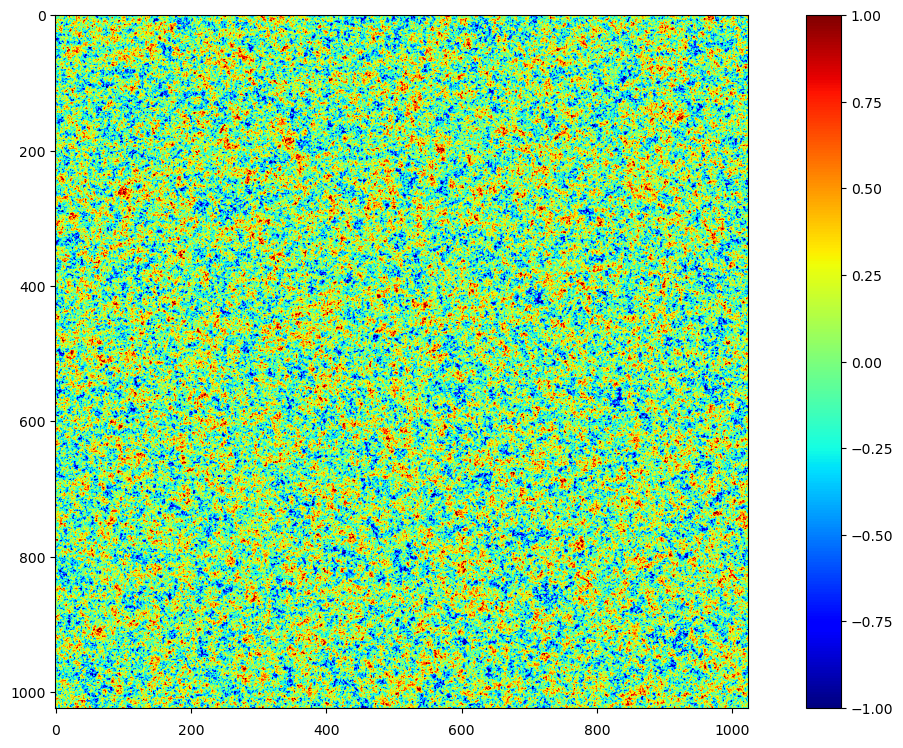

In [50]:
kappa_map = fields.get_map("k", fft=False)
plt.imshow(kappa_map, cmap="jet", vmin=-1, vmax=1)
plt.colorbar()

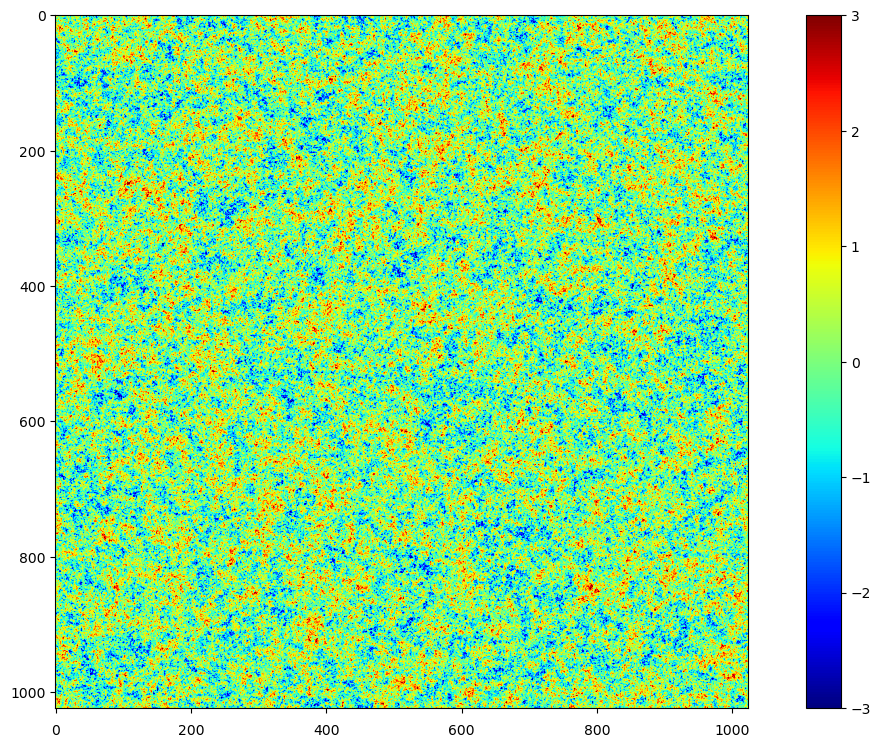

In [51]:
gal_map = fields.get_map("g", fft=False)
plt.imshow(gal_map, cmap="jet", vmin=-3, vmax=3)
plt.colorbar()

In [52]:
ells = np.arange(30,3001)
fiducial_kg = power.get_ps("kg", ells)

In [62]:
fields_kg, ks_bin, err_bin = fields.get_ps_binned(fields.get_map("k"), fields.get_map("g"),kmin=30, kmax=3000, nBins=50)


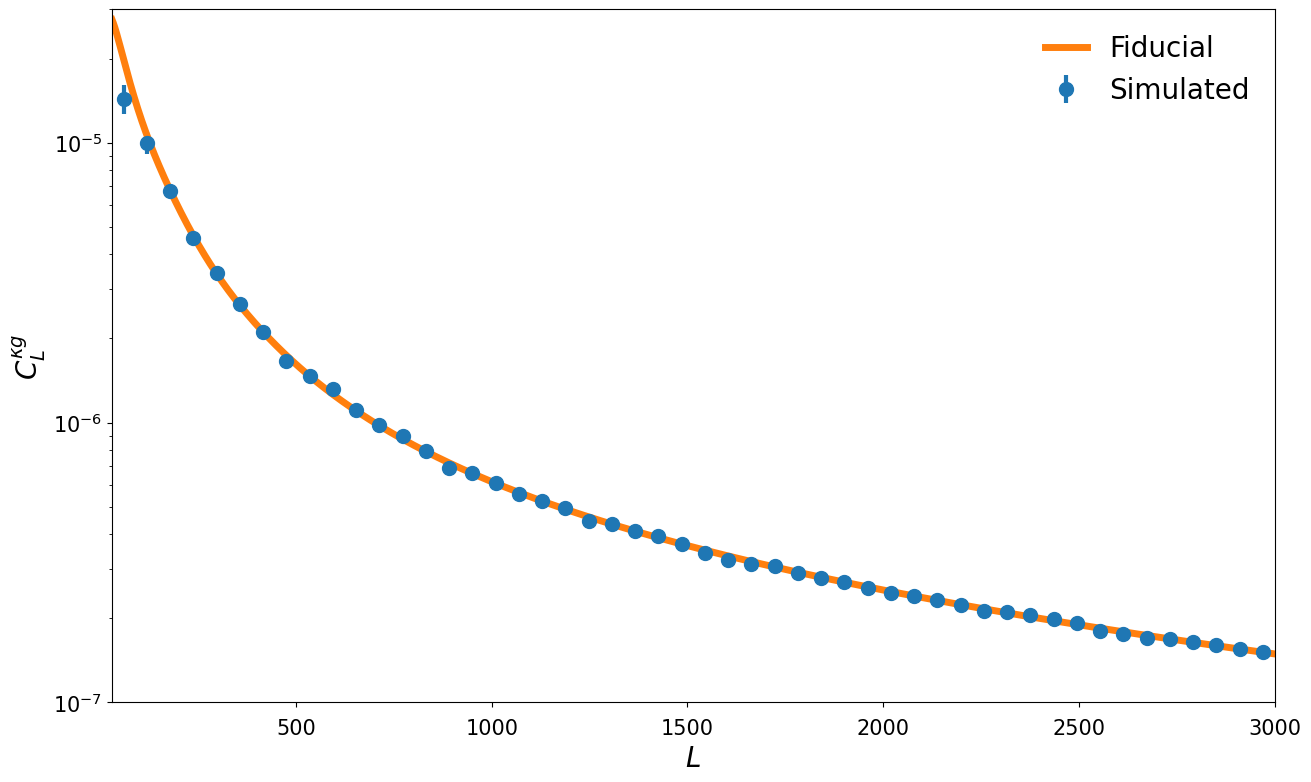

In [116]:
plt.errorbar(ks_bin, fields_kg, err_bin, fmt=".", markersize=20, linewidth=3, label="Simulated")
plt.semilogy(ells, (2*np.pi)**2*fiducial_kg, linewidth=5, label="Fiducial")
plt.ylabel("$C_L^{\kappa g}$", fontsize=20)
plt.xlabel("$L$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(1e-7,3e-5)
plt.xlim(30,3000)
plt.legend(prop={'size': 20}, frameon=False, handlelength=1.5)

In [84]:
def _C_inv_splines(LSS_fields, L_max_map=5000, L_min_cut=30, L_max_cut=3000):
    C_inv = fields.fish.covariance.get_C_inv(LSS_fields, L_max_map, 353e9)
    N_fields = np.size(list(LSS_fields))
    C_inv_splines = np.empty((N_fields, N_fields), dtype=InterpolatedUnivariateSpline)
    Ls = np.arange(L_max_map+1)
    for iii in range(N_fields):
        for jjj in range(N_fields):
            C_inv_ij = C_inv[iii, jjj]
            C_inv_ij[L_max_cut+1:] = 0
            C_inv_ij[:L_min_cut] = 0
            C_inv_splines[iii, jjj] = InterpolatedUnivariateSpline(Ls, C_inv_ij)
    return C_inv_splines

In [87]:
Ls = np.load(f"{omegaqe.RESULTS_DIR}/F_L_results/{LSS_fields}/{exp}/gmv/TEB/30_3000/1_2000/Ls.npy")
F_L_spline = InterpolatedUnivariateSpline(Ls, np.load(f"{omegaqe.RESULTS_DIR}/F_L_results/{LSS_fields}/{exp}/gmv/TEB/30_3000/1_2000/F_L.npy"))
%time C_inv_spline = _C_inv_splines(LSS_fields)


CPU times: user 2.73 s, sys: 1.39 s, total: 4.12 s
Wall time: 1.25 s


In [88]:
omega_tem = fields.get_omega_template(100, F_L_spline=F_L_spline, C_inv_spline=C_inv_spline, tracer_noise=True)

[0:00:58] 100%


In [92]:
omega_Ls, omega_ps_camb = power.cosmo.get_postborn_omega_ps(ellmax=8000)
omega_ps = postborn.omega_ps(omega_Ls) 
omega_ps_spline = InterpolatedUnivariateSpline(omega_Ls, omega_ps)

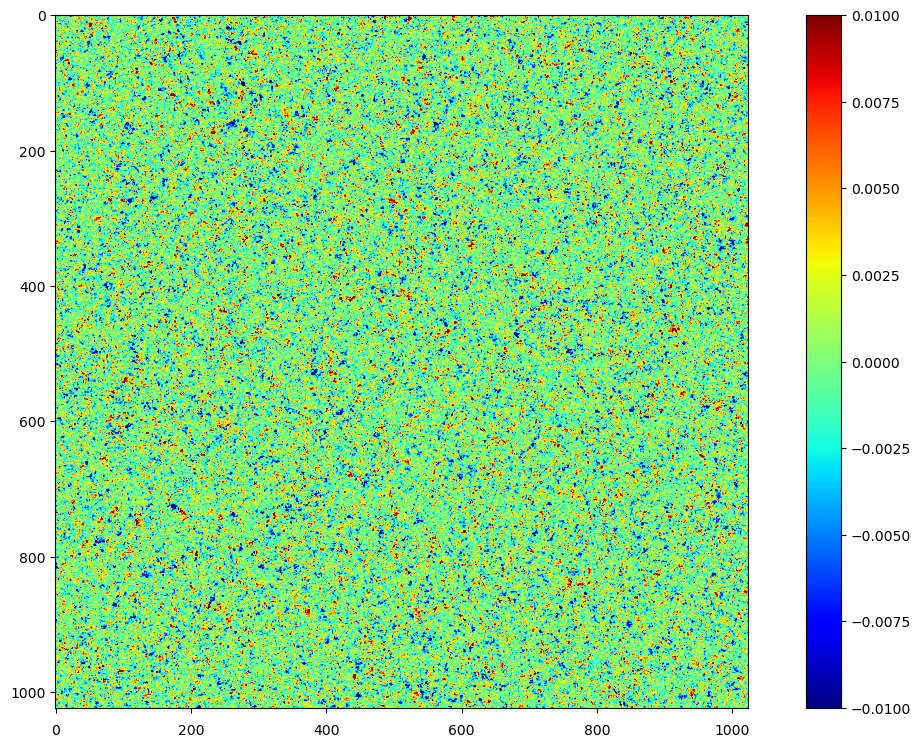

In [100]:
wiener = F_L_spline(fields.kM)
omega_tem_filt = omega_tem*wiener
plt.imshow(np.fft.irfft2(omega_tem_filt, norm="forward"), cmap="jet", vmin=-0.01, vmax=0.01)
plt.colorbar()

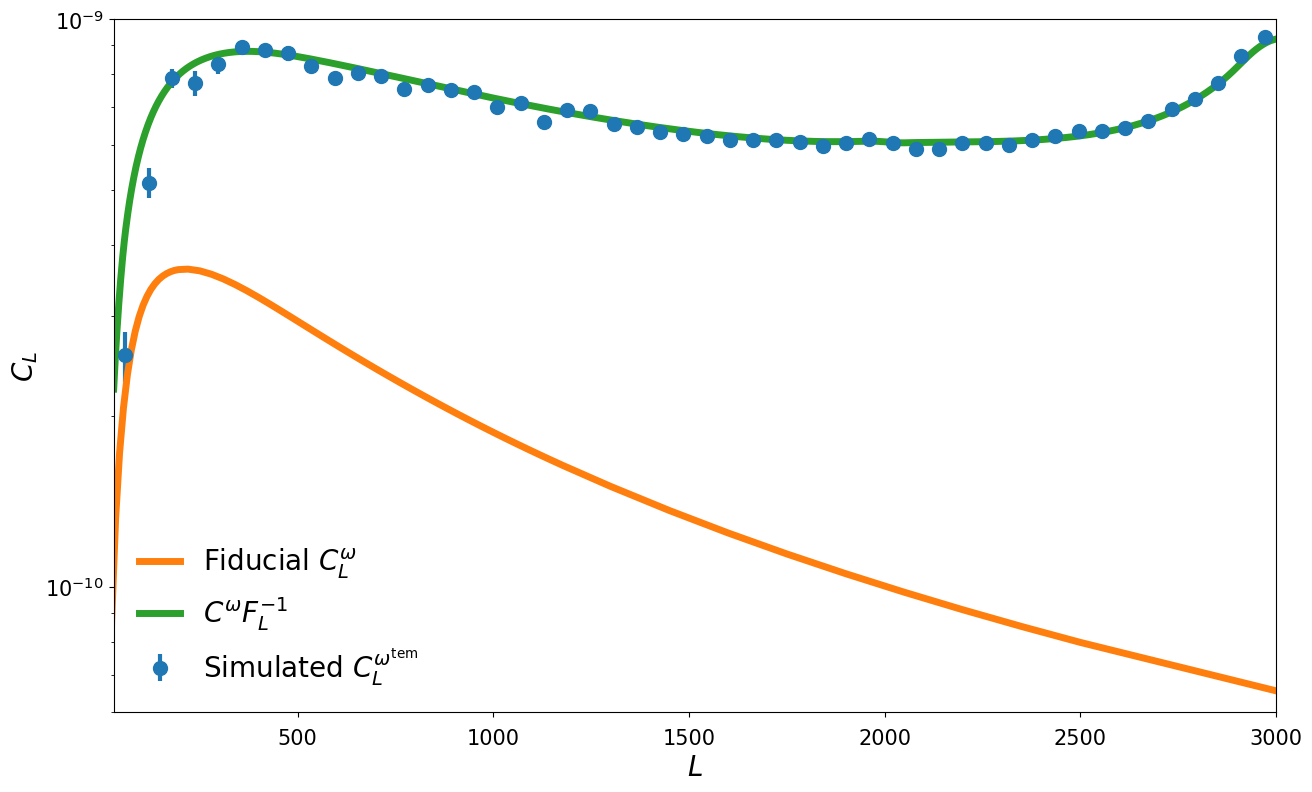

In [114]:
omega_tem_ps, om_ks_bin, om_err_bin = fields.get_ps_binned(omega_tem, kmin=30, kmax=3000, nBins=50)
plt.errorbar(om_ks_bin, omega_tem_ps, om_err_bin, fmt=".", markersize=20, linewidth=3, label="Simulated $C^{\omega^{\mathrm{tem}}}_L$")
plt.semilogy(omega_Ls, (2*np.pi)**2*omega_ps, linewidth=5, label="Fiducial $C^{\omega}_L$")
plt.semilogy(ells, (2*np.pi)**2*omega_ps_spline(ells)/F_L_spline(ells), linewidth=5, label="$C^{\omega}F_L^{-1}$")
plt.ylabel("$C_L$", fontsize=20)
plt.xlabel("$L$", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(6e-11,1e-9)
plt.xlim(30,3000)
plt.legend(prop={'size': 20}, frameon=False, handlelength=1.5)